In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import psutil
import os
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

c:\Users\nkasa\OneDrive\Desktop\Python Basics\sklearn-env\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
# Print loading message
print("Loading data...")

Loading data...


In [3]:
# Load the data
tpot_data = pd.read_csv('3DCN-2022.csv')

In [4]:
# Print dataset info
print("\nDataset Information:")
print(f"Total number of rows: {len(tpot_data)}")
print(f"Columns in dataset: {tpot_data.columns.tolist()}")
print("\nFirst few rows of data:")
print(tpot_data.head())


Dataset Information:
Total number of rows: 1321
Columns in dataset: ['Materials type', 'Materials Name', 'Electrolyte', 'Voltage (V)', 'Specific surface area (m2/g)', 'Pore volume (cm3/g)', 'IDIG', 'N-doped (at%)', 'O-doped (at%)', 'E-type', 'Current density (A/g)', 'Capacitance (F/g)']

First few rows of data:
  Materials type Materials Name Electrolyte  Voltage (V)  \
0  porous carbon          cgacf         KOH          1.0   
1  porous carbon          cgacf         KOH          1.0   
2  porous carbon          cgacf         KOH          1.0   
3  porous carbon          cgacf         KOH          1.0   
4  porous carbon          cgacf         KOH          1.0   

   Specific surface area (m2/g)  Pore volume (cm3/g)  IDIG  N-doped (at%)  \
0                        1435.0                 0.87  0.87            0.0   
1                        1435.0                 0.87  0.87            0.0   
2                        1435.0                 0.87  0.87            0.0   
3                

In [5]:
# Identify categorical columns
categorical_columns = tpot_data.select_dtypes(include=['object']).columns
print(f"\nCategorical columns found: {list(categorical_columns)}")


Categorical columns found: ['Materials type', 'Materials Name', 'Electrolyte']


In [6]:
# Convert categorical columns to numeric using one-hot encoding
tpot_data = pd.get_dummies(tpot_data, columns=categorical_columns)
print("\nShape after one-hot encoding:", tpot_data.shape)


Shape after one-hot encoding: (1321, 234)


In [7]:
# Prepare features and target
target_column = 'Capacitance (F/g)'
features = tpot_data.drop(target_column, axis=1)

In [8]:
# Add Feature Selection Steps
print("\nPerforming feature selection...")
# 1. Remove constant and quasi-constant features
variance_threshold = VarianceThreshold(threshold=0.01)  # Remove features with variance < 0.01
features_var = pd.DataFrame(variance_threshold.fit_transform(features), 
                            columns=features.columns[variance_threshold.get_support()])
print(f"Features remaining after variance threshold: {features_var.shape[1]}")


Performing feature selection...
Features remaining after variance threshold: 51


In [9]:
# 2. Remove highly correlated features
def remove_correlated_features(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(to_drop, axis=1)
features_uncorr = remove_correlated_features(features_var, threshold=0.95)
print(f"Features remaining after correlation analysis: {features_uncorr.shape[1]}")

Features remaining after correlation analysis: 51


In [10]:
# Split the data
print("\nSplitting data into training and testing sets...")
training_features, testing_features, training_target, testing_target = \
    train_test_split(features_uncorr, tpot_data[target_column], random_state=42, test_size=0.2)



Splitting data into training and testing sets...


In [11]:
# 3. Scale features
scaler = StandardScaler()
training_features_scaled = pd.DataFrame(scaler.fit_transform(training_features), 
                                        columns=training_features.columns)
testing_features_scaled = pd.DataFrame(scaler.transform(testing_features), 
                                       columns=testing_features.columns)

In [12]:
# Get system memory information
total_memory = psutil.virtual_memory().total / (1024.0 ** 2)
print(f"\nTotal System Memory: {total_memory:.2f} MB")

# Adjust XGBoost parameters based on system memory
if total_memory < 16384:  # 16 GB
    max_depth = 5
    n_estimators = 200
    subsample = 0.6
    colsample_bytree = 0.6
else:
    max_depth = 7
    n_estimators = 300
    subsample = 0.8
    colsample_bytree = 0.8


Total System Memory: 16270.52 MB


In [13]:

# 4. Create initial XGBoost model for feature importance selection with regularization
initial_model = XGBRegressor(
    learning_rate=0.1,
    max_depth=5,  # Reduce depth for regularization
    min_child_weight=1,
    n_estimators=100,  # Fewer estimators
    n_jobs=-1,
    objective="reg:squarederror",
    subsample=0.8,  # Adjusted subsample
    colsample_bytree=0.8,  # Adjusted colsample_bytree
    verbosity=0,
    alpha=0.1,  # L1 regularization
    lambda_=1  # L2 regularization
)

In [15]:
# 5. Select features based on importance
selector = SelectFromModel(initial_model, prefit=False, threshold='mean')
selector.fit(training_features_scaled, training_target)
training_features_selected = selector.transform(training_features_scaled)
testing_features_selected = selector.transform(testing_features_scaled)

print(f"Final number of selected features: {training_features_selected.shape[1]}")

Final number of selected features: 13


In [17]:
 #Split training data into training and validation sets for early stopping
X_train, X_val, y_train, y_val = train_test_split(training_features_selected, training_target, test_size=0.2, random_state=42)

In [22]:
# 6. Create the final XGBoost model
final_model = XGBRegressor(
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    n_estimators=100,
    n_jobs=-1,
    objective="reg:squarederror",
    subsample=0.8,
    colsample_bytree=0.8,
    verbosity=0,
    alpha=0.1,
    lambda_=1
)


In [25]:
print("\nTraining the model...")
# Create and train the pipeline with selected features
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=final_model),
    final_model
)


Training the model...


In [26]:

# Fix random state for reproducibility
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

In [27]:

# Fit the pipeline and make predictions
exported_pipeline.fit(training_features_selected, training_target)
print("Model training completed!")

Model training completed!


In [32]:
# Perform feature selection based on model importance (applied consistently to both training and testing)
print("\nPerforming feature selection...")

# Fit the feature selector using the training data
selector = SelectFromModel(initial_model, prefit=False, threshold='mean')
selector.fit(training_features_scaled, training_target)

# Transform both training and testing datasets to select the same features
training_features_selected = selector.transform(training_features_scaled)
testing_features_selected = selector.transform(testing_features_scaled)

print(f"Final number of selected features: {training_features_selected.shape[1]}")

# Now, train the pipeline with selected features
print("\nTraining the model...")

# Recreate the pipeline with selected features
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=XGBRegressor(
        learning_rate=0.1,
        max_depth=max_depth,
        min_child_weight=1,
        n_estimators=n_estimators,
        n_jobs=-1,
        objective="reg:squarederror",
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        verbosity=0
    )),
    XGBRegressor(
        learning_rate=0.1,
        max_depth=max_depth,
        min_child_weight=1,
        n_estimators=n_estimators,
        n_jobs=-1,
        objective="reg:squarederror",
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        verbosity=0
    )
)

# Fit the pipeline using the training data
exported_pipeline.fit(training_features_selected, training_target)
print("Model training completed!")

# Make predictions
print("\nMaking predictions...")
training_predictions = exported_pipeline.predict(training_features_selected)
testing_predictions = exported_pipeline.predict(testing_features_selected)

# Output the predictions for verification
print("Training predictions:", training_predictions[:5])  # Display first 5 predictions
print("Testing predictions:", testing_predictions[:5])   # Display first 5 predictions




Performing feature selection...
Final number of selected features: 13

Training the model...
Model training completed!

Making predictions...
Training predictions: [ 51.29198 290.33636 269.0914  242.07625 141.93434]
Testing predictions: [236.51637   192.81444   201.33943    86.208015   -2.0345774]


In [33]:
# Calculate performance metrics
train_mse = mean_squared_error(training_target, training_predictions)
test_mse = mean_squared_error(testing_target, testing_predictions)
train_r2 = r2_score(training_target, training_predictions)
test_r2 = r2_score(testing_target, testing_predictions)

# Output the performance metrics
print("\nModel Performance Metrics:")
print(f"Training MSE: {train_mse:.2f}")
print(f"Testing MSE: {test_mse:.2f}")
print(f"Training R² Score: {train_r2:.2f}")
print(f"Testing R² Score: {test_r2:.2f}")



Model Performance Metrics:
Training MSE: 1062.23
Testing MSE: 1776.43
Training R² Score: 0.86
Testing R² Score: 0.77


In [34]:
# Get feature importance from the final XGBoost model
final_model = exported_pipeline.steps[-1][1]
feature_importance = final_model.feature_importances_
feature_names = training_features.columns
importance_dict = dict(zip(feature_names, feature_importance))

In [35]:
print("\nFeature Importance:")
for feature, importance in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")


Feature Importance:
Voltage (V): 0.2426
IDIG: 0.1648
Materials type_CDC: 0.1409
O-doped (at%): 0.1397
Current density (A/g): 0.0663
Pore volume (cm3/g): 0.0450
Materials type_3D carbon: 0.0390
Specific surface area (m2/g): 0.0320
E-type: 0.0305
Materials type_N-doped graphene: 0.0282
Materials type_AC: 0.0216
Materials type_N-doped carbon: 0.0203
Materials type_N-doped carbon nanobelt: 0.0177
N-doped (at%): 0.0115


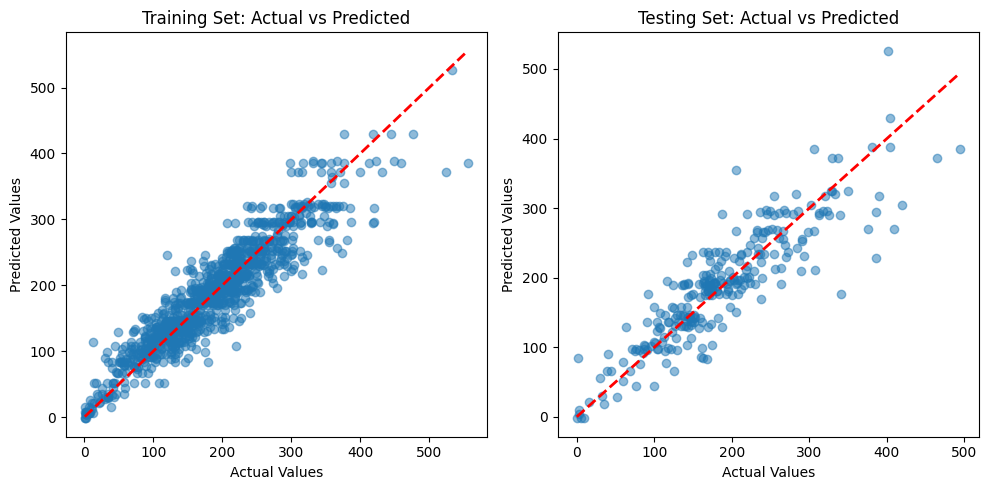

In [36]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 5))

# Training set
plt.subplot(1, 2, 1)
plt.scatter(training_target, training_predictions, alpha=0.5)
plt.plot([training_target.min(), training_target.max()], [training_target.min(), training_target.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training Set: Actual vs Predicted')

# Testing set
plt.subplot(1, 2, 2)
plt.scatter(testing_target, testing_predictions, alpha=0.5)
plt.plot([testing_target.min(), testing_target.max()], [testing_target.min(), testing_target.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Testing Set: Actual vs Predicted')

plt.tight_layout()
plt.show()

In [37]:
# Save predictions to CSV
results_df = pd.DataFrame({
    'Actual': testing_target,
    'Predicted': testing_predictions
})
results_df.to_csv('prediction_results3.csv', index=False)
print("\nPrediction results have been saved to 'prediction_results2.csv'")


Prediction results have been saved to 'prediction_results2.csv'
